In [4]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# set seed to reproduce similar results
np.random.seed(0)

In [5]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + './human+activity+recognition+using+smartphones/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + './human+activity+recognition+using+smartphones/UCI HAR Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [6]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [7]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()

(470528, 9)


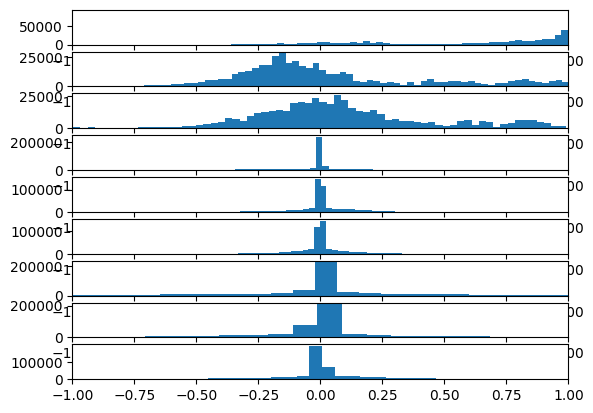

In [8]:
# plot distributions
plot_distributions(trainX)

In [9]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [28]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model1 = Sequential()
model1.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model1.add(Dropout(0.5))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(n_outputs, activation='softmax'))
plot_model(model1, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [29]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
# fit network
train_epochs = 10
history1 = model1.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 10s 95ms/step - loss: 1.2206 - accuracy: 0.4945 - val_loss: 1.0370 - val_accuracy: 0.5840
Epoch 2/10
92/92 [==============================] - 8s 85ms/step - loss: 0.8251 - accuracy: 0.6501 - val_loss: 0.9108 - val_accuracy: 0.6377
Epoch 3/10
92/92 [==============================] - 8s 89ms/step - loss: 0.6435 - accuracy: 0.7300 - val_loss: 0.7955 - val_accuracy: 0.7417
Epoch 4/10
92/92 [==============================] - 8s 89ms/step - loss: 0.5373 - accuracy: 0.7786 - val_loss: 0.6615 - val_accuracy: 0.7852
Epoch 5/10
92/92 [==============================] - 8s 89ms/step - loss: 0.4793 - accuracy: 0.8288 - val_loss: 0.6565 - val_accuracy: 0.8083
Epoch 6/10
92/92 [==============================] - 8s 91ms/step - loss: 0.4028 - accuracy: 0.8493 - val_loss: 0.6010 - val_accuracy: 0.8171
Epoch 7/10
92/92 [==============================] - 8s 91ms/step - loss: 0.3995 - accuracy: 0.8624 - val_loss: 0.4561 - val_accuracy: 0.8783
Epoch 8/10
9

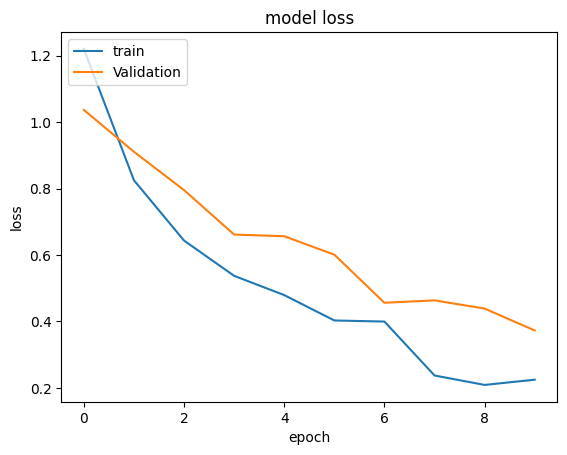

In [31]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [32]:
# evaluate model
test_loss, test_accuracy = model1.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the LSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model1.predict(testX)

Accuracy of the LSTM model 0.8998982310295105
93/93 [==============================] - 2s 18ms/step


In [33]:
predictions

array([[1.7866174e-03, 3.6941892e-05, 2.9879263e-06, 9.1933068e-03,
        9.8897856e-01, 1.5929953e-06],
       [1.3195920e-03, 3.0168580e-05, 2.4669989e-06, 8.4920339e-03,
        9.9015433e-01, 1.4549827e-06],
       [1.3171014e-03, 2.9647133e-05, 2.3870136e-06, 8.0431486e-03,
        9.9060631e-01, 1.3582051e-06],
       ...,
       [1.8307667e-02, 9.7777075e-01, 3.9074626e-03, 3.6848664e-06,
        9.3259086e-06, 1.0114479e-06],
       [3.3388250e-02, 9.5829099e-01, 7.7427826e-03, 1.8745309e-04,
        2.9793833e-04, 9.2632523e-05],
       [3.1732891e-03, 9.9545443e-01, 1.0763952e-03, 8.2255770e-05,
        7.4263291e-05, 1.3939540e-04]], dtype=float32)

In [34]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[463  15  17   1   0   0]
 [ 12 427  30   2   0   0]
 [  2   5 413   0   0   0]
 [ 20   4   0 377  90   0]
 [  8   0   0  60 464   0]
 [  0  29   0   0   0 508]]
**** Classification Report ****
                    precision    recall  f1-score   support

           WALKING       0.92      0.93      0.93       496
  WALKING_UPSTAIRS       0.89      0.91      0.90       471
WALKING_DOWNSTAIRS       0.90      0.98      0.94       420
           SITTING       0.86      0.77      0.81       491
          STANDING       0.84      0.87      0.85       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.90      2947
         macro avg       0.90      0.90      0.90      2947
      weighted avg       0.90      0.90      0.90      2947



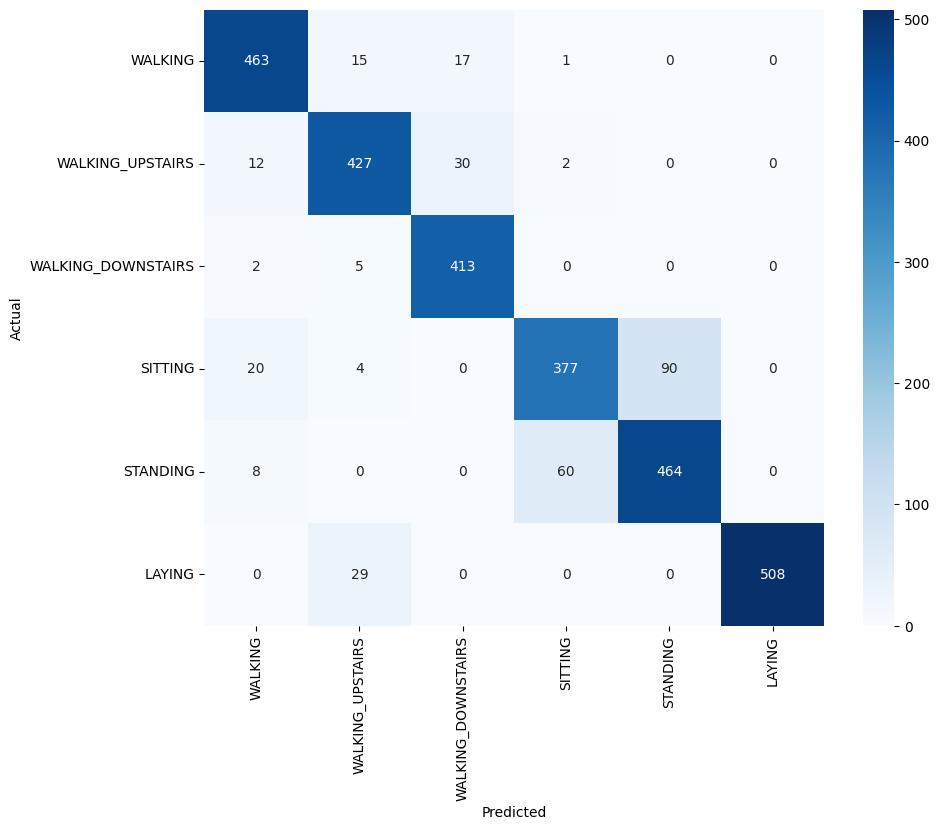

In [35]:
classNames=["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"]
display_results(testy,predictions,classNames)

In [44]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model2 = Sequential()
model2.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model2.add(Dropout(0.5))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model2.add(Dropout(0.5))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(100, activation='relu'))
model2.add(Dense(50, activation='relu'))
model2.add(Dense(n_outputs, activation='softmax'))
plot_model(model2, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [45]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
# fit network
train_epochs = 20
history2 = model2.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/20
92/92 [==============================] - 3s 21ms/step - loss: 0.5721 - accuracy: 0.7665 - val_loss: 0.4933 - val_accuracy: 0.8654
Epoch 2/20
92/92 [==============================] - 2s 19ms/step - loss: 0.1913 - accuracy: 0.9240 - val_loss: 0.3276 - val_accuracy: 0.9075
Epoch 3/20
92/92 [==============================] - 2s 20ms/step - loss: 0.1319 - accuracy: 0.9469 - val_loss: 0.3113 - val_accuracy: 0.9035
Epoch 4/20
92/92 [==============================] - 2s 27ms/step - loss: 0.1376 - accuracy: 0.9483 - val_loss: 0.3171 - val_accuracy: 0.9041
Epoch 5/20
92/92 [==============================] - 3s 27ms/step - loss: 0.0935 - accuracy: 0.9585 - val_loss: 0.2853 - val_accuracy: 0.9075
Epoch 6/20
92/92 [==============================] - 2s 21ms/step - loss: 0.0972 - accuracy: 0.9566 - val_loss: 0.2851 - val_accuracy: 0.8817
Epoch 7/20
92/92 [==============================] - 2s 20ms/step - loss: 0.0846 - accuracy: 0.9623 - val_loss: 0.2828 - val_accuracy: 0.9103
Epoch 8/20
92

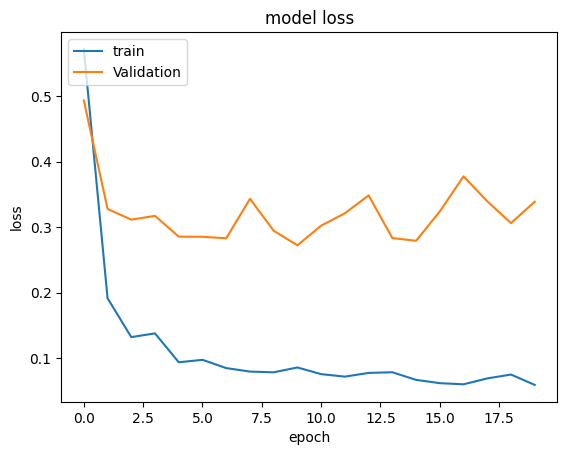

In [47]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [48]:
# evaluate model
test_loss, test_accuracy = model2.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model2.predict(testX)

Accuracy of the CNN model 0.9110960364341736
93/93 [==============================] - 0s 3ms/step


**** Confusion Matrix ****
[[468   3  25   0   0   0]
 [  0 448  22   0   0   1]
 [  0   0 420   0   0   0]
 [  0   2   0 415  68   6]
 [  0   1   0 107 424   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
                    precision    recall  f1-score   support

           WALKING       1.00      0.94      0.97       496
  WALKING_UPSTAIRS       0.93      0.95      0.94       471
WALKING_DOWNSTAIRS       0.90      1.00      0.95       420
           SITTING       0.80      0.85      0.82       491
          STANDING       0.86      0.80      0.83       532
            LAYING       0.99      0.95      0.97       537

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.91      0.91      2947



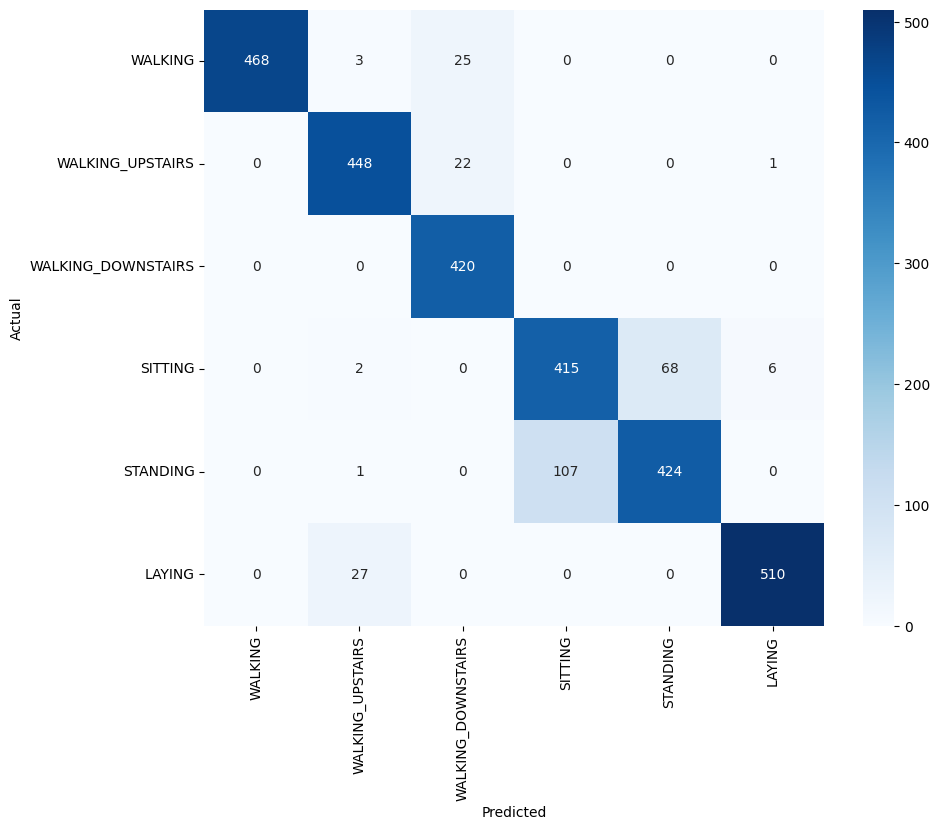

In [49]:
display_results(testy,predictions,classNames)

In [50]:
# we will select the first sample from the test set
sample = testX[0]
sample.shape

(128, 9)

In [51]:
# predict the results using the model, we need to input in the form of (numberOfSamples,featureLength,numberOfFeatures)
predictionForSample = model2.predict(sample.reshape(1,sample.shape[0],sample.shape[1]))

1/1 [==============================] - 0s 19ms/step


In [52]:
# get the class of the sample
samplePredictedClass = np.argmax(predictionForSample, axis=1)
sampleActualClass = np.argmax(testy, axis=1)
print("Actual class: ",sampleActualClass[0])
print("Predicted class: ",samplePredictedClass[0])

Actual class:  4
Predicted class:  4


In [53]:
# 모델 초기화
model3 = Sequential()

# CNN 레이어
model3.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model3.add(MaxPooling1D(pool_size=2))

# LSTM 레이어
model3.add(LSTM(100, input_shape=(n_timesteps,n_features)))  # return_sequences=True로 설정하여 모든 시간 단계의 출력을 반환

# Flatten 레이어
model3.add(Flatten())

# 출력 Dense 레이어
model3.add(Dense(n_outputs, activation='softmax'))

# 모델 컴파일
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [54]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 63, 64)           0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 100)               66000     
                                                                 
 flatten_3 (Flatten)         (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 6)                 606       
                                                                 
Total params: 68,398
Trainable params: 68,398
Non-trainable params: 0
__________________________________________________

In [55]:
# fit network
train_epochs = 10
history3 = model3.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 7s 57ms/step - loss: 0.8901 - accuracy: 0.6390 - val_loss: 0.7210 - val_accuracy: 0.7301
Epoch 2/10
92/92 [==============================] - 5s 53ms/step - loss: 0.5404 - accuracy: 0.7839 - val_loss: 0.5824 - val_accuracy: 0.7838
Epoch 3/10
92/92 [==============================] - 5s 59ms/step - loss: 0.3887 - accuracy: 0.8524 - val_loss: 0.4271 - val_accuracy: 0.8695
Epoch 4/10
92/92 [==============================] - 5s 49ms/step - loss: 0.2589 - accuracy: 0.9072 - val_loss: 0.4131 - val_accuracy: 0.8613
Epoch 5/10
92/92 [==============================] - 6s 62ms/step - loss: 0.2324 - accuracy: 0.9233 - val_loss: 0.3864 - val_accuracy: 0.8797
Epoch 6/10
92/92 [==============================] - 5s 55ms/step - loss: 0.1634 - accuracy: 0.9400 - val_loss: 0.4091 - val_accuracy: 0.8851
Epoch 7/10
92/92 [==============================] - 5s 55ms/step - loss: 0.1533 - accuracy: 0.9437 - val_loss: 0.3757 - val_accuracy: 0.9055
Epoch 8/10
92

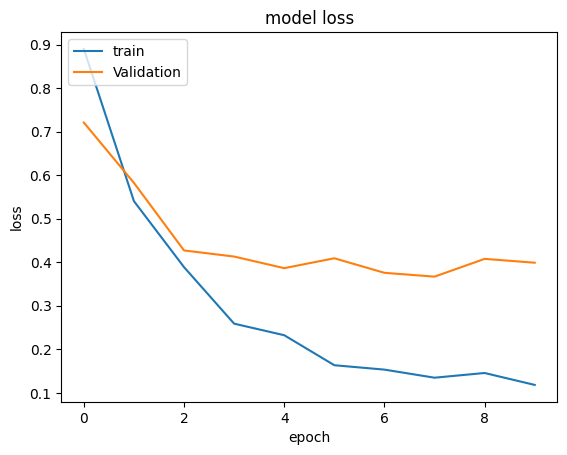

In [56]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [57]:
# evaluate model
test_loss, test_accuracy = model3.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model3.predict(testX)

Accuracy of the CNN model 0.8873430490493774
93/93 [==============================] - 1s 9ms/step


In [59]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense

model4 = Sequential()

# Bidirectional LSTM 레이어
model4.add(Bidirectional(LSTM(100, input_shape=(n_timesteps,n_features))))
model4.add(Dropout(0.5))
model4.add(Dense(100, activation='relu'))

# 출력 Dense 레이어
model4.add(Dense(n_outputs, activation='softmax'))

# 모델 컴파일
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
# fit network
train_epochs = 10
history4 = model4.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 28s 276ms/step - loss: 1.2252 - accuracy: 0.4788 - val_loss: 1.1056 - val_accuracy: 0.5581
Epoch 2/10
92/92 [==============================] - 24s 264ms/step - loss: 0.8727 - accuracy: 0.6433 - val_loss: 0.8261 - val_accuracy: 0.6920
Epoch 3/10
92/92 [==============================] - 24s 259ms/step - loss: 0.7297 - accuracy: 0.7079 - val_loss: 0.7766 - val_accuracy: 0.7165
Epoch 4/10
92/92 [==============================] - 24s 260ms/step - loss: 0.5556 - accuracy: 0.7803 - val_loss: 0.7420 - val_accuracy: 0.7648
Epoch 5/10
92/92 [==============================] - 25s 267ms/step - loss: 0.4332 - accuracy: 0.8424 - val_loss: 0.7772 - val_accuracy: 0.8246
Epoch 6/10
92/92 [==============================] - 26s 280ms/step - loss: 0.3536 - accuracy: 0.8788 - val_loss: 0.6886 - val_accuracy: 0.8035
Epoch 7/10
92/92 [==============================] - 25s 274ms/step - loss: 0.2864 - accuracy: 0.9032 - val_loss: 0.5654 - val_accuracy: 0.8491

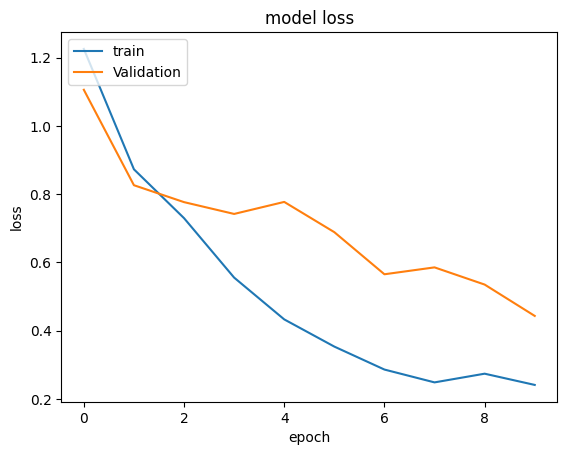

In [63]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [62]:
# evaluate model
test_loss, test_accuracy = model4.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model4.predict(testX)

Accuracy of the CNN model 0.854428231716156
93/93 [==============================] - 3s 24ms/step
